In [1]:
### set up the notebook
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
np.set_printoptions(linewidth=100) 

plt.rcParams.update({'font.size': 14})

In [2]:
def remove_outliers_IQR(data, limit):
    len_nan = len(data[np.isnan(data)])
    q1 = np.nanpercentile(data, 25)
    q3 = np.nanpercentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - limit * iqr
    upper_bound = q3 + limit * iqr
    # where data is outside bounds, replace with nan
    data_cp = data.copy()
    data_cp[(data_cp < lower_bound) | (data_cp > upper_bound)] = np.nan
    print('Removed %d / %d points' % (np.sum(np.isnan(data_cp))-len_nan, len(data.flatten())))
    return data_cp

In [3]:
### load the L2 PIB, PGC, L3 expert, buoy cross track fits and buoy SSH data

swot = xr.open_mfdataset('./data/SWOT_products_at_buoys.nc')
buoy = xr.open_dataset('./data/GNSS_at_SWOT_times.nc')
buoy_xt_cor = xr.open_mfdataset('./data/GNSS_derived_xt_correction.nc')

# create swot time array
swot_time = swot.time.values

In [4]:
### apply corrections to SWOT SSH to make it comparable to buoys (solid earth, SE of pole tide, ocean tidal loading)

h2 = 0.6207
k2 = 0.302
pole_factor = h2 / (1 + k2)

swot['ssh_comparison'] = swot.PGC_ssh_karin_2 - swot.PGC_solid_earth_tide - swot.PGC_load_tide_fes - swot.PGC_pole_tide * pole_factor

# apply quality flag, preserving points at buoy closest to the coast which would otherwise be discarded
swot['ssh_comparison'] = swot['ssh_comparison'].where(swot.PGC_ssh_karin_2_qual < 257)

# apply quality flag to PGC0 and L3 cross over corrections (but not PIB as this removed almost all the data)
swot['PGC_height_cor_xover'] = swot['PGC_height_cor_xover'].where(swot.PGC_height_cor_xover_qual < 1)
swot['L3_calibration'] = swot['L3_calibration'].where(swot.L3_quality_flag < 1)

# # apply quality flag to buoy
buoy['ssh'] = buoy['ssh'].where(buoy.ssh_quality <2)

In [5]:
### calculate residuals for cycles with data from at least 7 buoys

PIB_resid = (swot.PIB_height_cor_xover.values + swot.ssh_comparison) - buoy.ssh.values
PGC_resid = (swot.PGC_height_cor_xover.values + swot.ssh_comparison) - buoy.ssh.values
L3_resid = (swot.L3_calibration.values + swot.ssh_comparison) - buoy.ssh.values
linear_resid = (swot.ssh_comparison - buoy_xt_cor.linear_fit) - buoy.ssh.values
plane_resid = (swot.ssh_comparison - buoy_xt_cor.plane_fit) - buoy.ssh.values

for i in range(96):
    if len(buoy.ssh[:,i].values[~np.isnan(buoy.ssh[:,i].values)])<7:
        PIB_resid[:,i] = np.ones((9))*np.nan
        PGC_resid[:,i] = np.ones((9))*np.nan
        L3_resid[:,i] = np.ones((9))*np.nan
        linear_resid[:,i] = np.ones((9))*np.nan
        plane_resid[:,i] = np.ones((9))*np.nan

In [8]:
### remove 1.5 * IQR outliers

PIB_resid_clean = remove_outliers_IQR(PIB_resid.values, 1.5)
PGC_resid_clean = remove_outliers_IQR(PGC_resid.values, 1.5)
L3_resid_clean = remove_outliers_IQR(L3_resid.values, 1.5)
linear_resid_clean = remove_outliers_IQR(linear_resid.values, 1.5)
plane_resid_clean = remove_outliers_IQR(plane_resid.values, 1.5)


Removed 13 / 864 points
Removed 13 / 864 points
Removed 11 / 864 points
Removed 8 / 864 points
Removed 6 / 864 points


In [9]:
### calculate daily std for each dataset

PIB_resid_clean_daily_std = np.nanstd(PIB_resid_clean, axis=0)
PGC_resid_clean_daily_std = np.nanstd(PGC_resid_clean, axis=0)
L3_resid_clean_daily_std = np.nanstd(L3_resid_clean, axis=0)
linear_resid_clean_daily_std = np.nanstd(linear_resid_clean, axis=0)
plane_resid_clean_daily_std = np.nanstd(plane_resid_clean, axis=0)


/working/hendreya/python_venvs/for_xarray/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


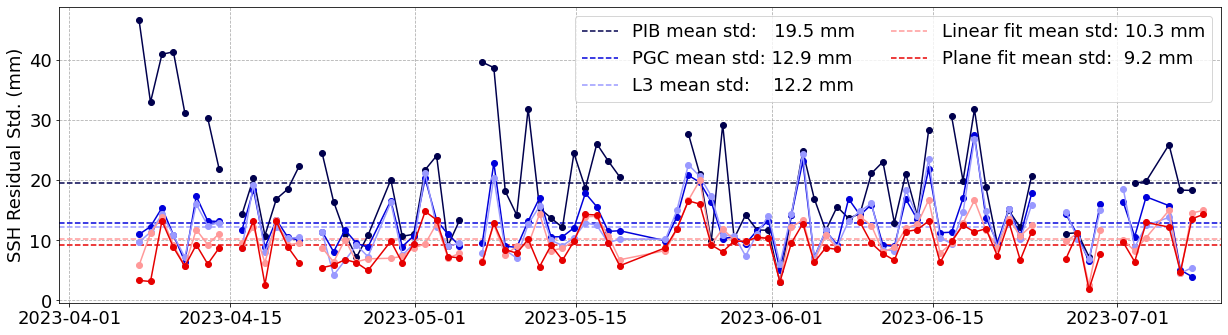

In [10]:
### plot the results

# create a 5 point array of colors
line_col = plt.cm.seismic(np.linspace(0, 1, 6))

fig_width = 17.4 #*cm
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(1, figsize=(fig_width,5))
ax.axhline(y = np.nanmean(PIB_resid_clean_daily_std*1000), linestyle='--', c=line_col[0], label=('PIB mean std:   %0.1f mm' % np.nanmean(PIB_resid_clean_daily_std*1000)))
ax.axhline(y = np.nanmean(PGC_resid_clean_daily_std*1000), linestyle='--', c=line_col[1], label=('PGC mean std: %0.1f mm' % np.nanmean(PGC_resid_clean_daily_std*1000)))
ax.axhline(y = np.nanmean(L3_resid_clean_daily_std*1000), linestyle='--', c=line_col[2], label=('L3 mean std:    %0.1f mm' % np.nanmean(L3_resid_clean_daily_std*1000)))
ax.axhline(y = np.nanmean(linear_resid_clean_daily_std*1000), linestyle='--', c=line_col[3], label=('Linear fit mean std: %0.1f mm' % np.nanmean(linear_resid_clean_daily_std*1000)))
ax.axhline(y = np.nanmean(plane_resid_clean_daily_std*1000), linestyle='--', c=line_col[4], label=('Plane fit mean std:  %0.1f mm' % np.nanmean(plane_resid_clean_daily_std*1000)))


ax.plot(swot_time, PIB_resid_clean_daily_std*1000, marker='o', c=line_col[0])
ax.plot(swot_time, PGC_resid_clean_daily_std*1000, marker='o', c=line_col[1])
ax.plot(swot_time, L3_resid_clean_daily_std*1000, marker='o', c=line_col[2])
ax.plot(swot_time, linear_resid_clean_daily_std*1000, marker='o', c=line_col[3])
ax.plot(swot_time, plane_resid_clean_daily_std*1000, marker='o', c=line_col[4])

ax.legend(ncol=2)#bbox_to_anchor=(0.12,0.53))
ax.set_xlim(swot_time[0], np.datetime64('2023-07-10'))
ax.set_ylabel('SSH Residual Std. (mm)')
ax.grid(linestyle='--')

plt.tight_layout()
plt.show()
